## 准备工作

1.确保您按照[README](README-CN.md)中的说明在环境中设置了API密钥

2.安装依赖包

In [1]:
!pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy

## 1. 生成 Embedding (基于 text-embedding-ada-002 模型)

嵌入对于处理自然语言和代码非常有用，因为其他机器学习模型和算法（如聚类或搜索）可以轻松地使用和比较它们。

In [2]:
# 导入 pandas 包。Pandas 是一个用于数据处理和分析的 Python 库
# 提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作。
import pandas as pd
# 导入 tiktoken 库。Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken
# 从 openai.embeddings_utils 包中导入 get_embedding 函数。
# 这个函数可以获取 GPT-3 模型生成的嵌入向量。
# 嵌入向量是模型内部用于表示输入数据的一种形式。
from openai.embeddings_utils import get_embedding

#### 加载数据集

In [4]:
input_data_path = "data/bug_analyze.csv"
df = pd.read_csv(input_data_path, index_col=0)
df = df[["time", "title", "reason", "group", "business"]]
df.dropna(inplace=True)

# 将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df["combined"] = (
    "Title: "+ df.title.str.strip() +"; business: " + df.business.str.strip() + " Content: " + df.reason.str.strip()
)
df.head(2)

,time,title,reason,group,business,combined
0,2023-07-26 17:36:52,【三色鸽】对接日志显示成功，但物料没有传到U8,并发过高，取号器取到相同号码，后续做并发优化处理，现可点重发解决,项目组,库存,Title: 【三色鸽】对接日志显示成功，但物料没有传到U8; business: 库存 C...
1,2023-07-26 17:17:28,【德州敏驰】用户在APP端进行操作扫码备料出库，扫码时使用备料出库的扫码方式，此时，查看基本...,按单维度初始值的问题,移动端,生产管理,Title: 【德州敏驰】用户在APP端进行操作扫码备料出库，扫码时使用备料出库的扫码方式，...


In [63]:
df["combined"]

0      Title: 【三色鸽】对接日志显示成功，但物料没有传到U8; business: 库存 C...
1      Title: 【德州敏驰】用户在APP端进行操作扫码备料出库，扫码时使用备料出库的扫码方式，...
2      Title: 【东莞市皖太电子科技有限公司】-物料已上传物料图，但是app的待领料列表操作的...
3      Title: 嘉益：成品入库任务下达成功，WMS那边回调成功。但是我们系统界面没有将WMS返...
4      Title: 【南京川木】销售出库同步应收单数据缺失; business: X Conten...
                             ...                        
700    Title: CoreBI表格组件，数据列设置的条件样式，实际显示时不对; business...
701    Title: 历史数据配置的消息通知不生效; business: CorePaaS Cont...
702    Title: nosp商品查看开通租户，切换开通租户分页时，左下角会闪一下共undefine...
703    Title: 酷工厂：报表系统6天崩了3次，问题反复且未解决！; business: 酷工厂...
704     Title: 生产单无法重置，重置报错; business: 酷工厂 Content: 历史问题
Name: combined, Length: 704, dtype: object

#### Embedding 模型关键参数

In [5]:
# 模型类型
# 建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
embedding_model = "text-embedding-ada-002"
# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = "cl100k_base"
# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000  

#### 将样本减少到最近的1,000个评论，并删除过长的样本


In [6]:
# 设置要筛选的评论数量为1000
top_n = 1000
# 对DataFrame进行排序，基于"Time"列，然后选取最后的2000条评论。
# 这个假设是，我们认为最近的评论可能更相关，因此我们将对它们进行初始筛选。
df = df.sort_values("time").tail(top_n * 2)
# 丢弃"Time"列，因为我们在这个分析中不再需要它。
df.drop("time", axis=1, inplace=True)
# 从'embedding_encoding'获取编码
encoding = tiktoken.get_encoding(embedding_encoding)

# 计算每条评论的token数量。我们通过使用encoding.encode方法获取每条评论的token数，然后把结果存储在新的'n_tokens'列中。
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

# 如果评论的token数量超过最大允许的token数量，我们将忽略（删除）该评论。
# 我们使用.tail方法获取token数量在允许范围内的最后top_n（1000）条评论。
df = df[df.n_tokens <= max_tokens].tail(top_n)

# 打印出剩余评论的数量。
len(df)

704

#### 生成 Embeddings 并保存（非必须步骤，可直接复用项目中文件）

In [16]:
# 实际生成会耗时几分钟
# 提醒：非必须步骤，可直接复用项目中的嵌入文件 fine_food_reviews_with_embeddings_1k
from concurrent.futures import ThreadPoolExecutor, as_completed

def fuc():
    df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))

print("开始处理。。。")
with ThreadPoolExecutor(max_workers=24) as executor:
    count = 1
    tasks = [executor.submit(fuc) for j in range(50)]
    for j in as_completed(tasks):
        print(f"已处理{count}个")
        count += 1


# df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))

# output_data_path = "data/bug_analyze_embedding.csv"

# df.to_csv(output_data_path)
print("finished。。。。")

开始处理。。。


KeyboardInterrupt: 

## 2.读取 fine_food_reviews_with_embeddings_1k 嵌入文件

In [67]:
embedding_data_path = "data/bug_analyze_embedding.csv"

df_embedded = pd.read_csv(embedding_data_path, index_col=0)

#### 查看 Embedding 结果

In [68]:
df_embedded["embedding"]

704    [-0.020830344408750534, -0.028545288369059563,...
703    [-0.029162898659706116, -0.013757402077317238,...
702    [-0.007864433340728283, -0.025314759463071823,...
701    [-0.03011651523411274, -0.019429072737693787, ...
700    [-0.027081597596406937, 0.006805137265473604, ...
                             ...                        
4      [-0.02130860649049282, -0.0030974780675023794,...
3      [-0.00850922241806984, -0.017255006358027458, ...
2      [-0.018290076404809952, -0.002503254683688283,...
1      [0.006376957055181265, 0.005314711481332779, 0...
0      [-0.026178140193223953, -0.016794618219137192,...
Name: embedding, Length: 704, dtype: object

In [22]:
len(df_embedded["embedding"][0])

34360

In [23]:
type(df_embedded["embedding"][0])

str

In [24]:
df_embedded["embedding"][0]

'[-0.026480603963136673, -0.016744447872042656, 0.004755626432597637, 0.0028947291430085897, -0.026408053934574127, 0.01138303242623806, -0.0265241339802742, -0.007182410452514887, -0.008125555701553822, -0.027510808780789375, 0.009192034602165222, 0.01899348571896553, -0.01246402133256197, 0.0012006958713755012, -0.02401391789317131, -0.012159313075244427, -0.006446031853556633, 0.0013693737564608455, 0.022504886612296104, -0.020865265280008316, -0.013871483504772186, 0.03653597831726074, -0.01990761049091816, -0.014662274159491062, -0.003389880061149597, -0.010490672662854195, 0.02350607141852379, -0.013719129376113415, 0.01497423741966486, 0.014314035885035992, 0.0022508513648062944, -0.0018735934281721711, -0.01700562611222267, -0.015017767436802387, -0.011825584806501865, 0.00018658849876374006, -0.00614132359623909, -0.0051981788128614426, 0.014930707402527332, -0.014190701767802238, 0.032879479229450226, 0.0026226681657135487, 0.01826798915863037, 0.0022834986448287964, -0.00039

In [69]:
import ast

# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

In [70]:
len(df_embedded["embedding_vec"][0])

1536

In [37]:
df_embedded.head(2)

,title,reason,business,combined,n_tokens,embedding,embedding_vec
704,生产单无法重置，重置报错,历史问题,酷工厂,Title: 生产单无法重置，重置报错; business: 酷工厂 Content: 历史问题,31,"[-0.02125272899866104, -0.028365537524223328, ...","[-0.02125272899866104, -0.028365537524223328, ..."
703,酷工厂：报表系统6天崩了3次，问题反复且未解决！,慢sql太密集，线上cc实例炸了,酷工厂,Title: 酷工厂：报表系统6天崩了3次，问题反复且未解决！; business: 酷工厂...,60,"[-0.028920406475663185, -0.013566908426582813,...","[-0.028920406475663185, -0.013566908426582813,..."


## 3. 使用 t-SNE 可视化 1536 维 Embedding 美食评论

In [71]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [72]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [73]:
# 首先，确保你的嵌入向量都是等长的
assert df_embedded['embedding_vec'].apply(len).nunique() == 1

In [74]:
# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embedded['embedding_vec'].values)

In [75]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [76]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [99]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [78]:
switch = {
    "E":0,
    "M":1,
    "CorePaaS":2,
    "产品组":3
}
def switch_fuc(group):
    return switch.get(group, 4)

In [79]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引

fuc = lambda ele: switch.get(str(ele), 4)
color_indices = df_embedded.group.apply(switch_fuc)

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embedded.group.values)

In [80]:
[switch_fuc(bn) for bn in df_embedded.group]

[2,
 4,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 4,
 2,
 4,
 2,
 0,
 4,
 1,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 4,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 3,
 2,
 4,
 1,
 4,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 0,
 0,
 4,
 0,
 2,
 4,
 3,
 0,
 4,
 4,
 0,
 0,
 4,
 1,
 0,
 2,
 0,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 4,
 1,
 0,
 1,
 3,
 0,
 4,
 1,
 4,
 4,
 1,
 3,
 1,
 1,
 4,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 4,
 0,
 4,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 4,
 1,
 1,
 0,
 1,
 4,
 0,
 0,
 2,
 1,
 4,
 4,
 2,
 0,
 0,
 0,
 4,
 1,
 4,
 1,
 0,
 1,
 4,
 0,
 2,
 0,
 4,
 3,
 0,
 0,
 0,
 4,
 2,
 1,
 0,
 2,
 0,
 2,
 1,
 3,
 0,
 1,
 3,
 1,
 3,
 2,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 3,
 2,
 1,
 4,
 4,
 1,
 0,
 1,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 0,
 0,
 3,
 1,
 0,
 0,
 0,
 3,
 0,
 2,
 2,
 3,
 2,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 0,
 0,
 3,
 4,
 4,
 1,
 4,
 0,
 0,
 4,
 4,
 3,
 4,
 0,
 4,
 0,
 4,
 0,


Text(0.5, 1.0, 'newcore bug using t-SNE')

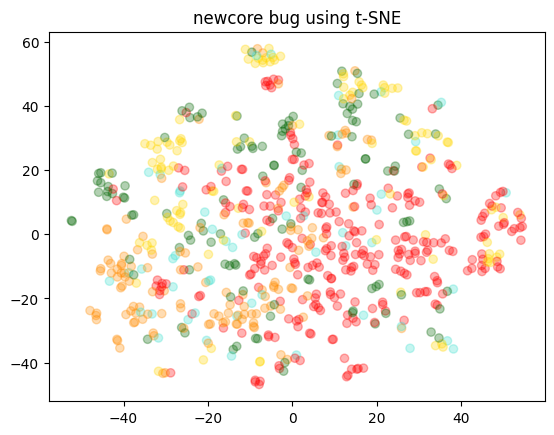

In [81]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("newcore bug using t-SNE")

**t-SNE降维后，产生了大约3个大类，其中1个大类的评论大多是负面的。**

## 4. 使用 K-Means 聚类，然后使用 t-SNE 可视化

In [100]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
# matrix = np.vstack(df.ada_embedding.values)

# 定义要生成的聚类数。
n_clusters = 5

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
# n_init=10 消除警告 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4'
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42, n_init=10)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded['Cluster'] = kmeans.labels_

In [92]:
from scipy.spatial.distance import cdist
cluster_centers = kmeans.cluster_centers_
distances = cdist(cluster_centers, matrix)
nearest_indices = np.argmin(distances, axis=1)
nearest_texts = df_embedded.iloc[nearest_indices]["combined"]
print(nearest_texts)

195    Title: 【兴顺】CPS表格报错; business: CorePaaS Content...
611    Title: 【巨将】用户生产单：B-230218-006，生产单开启了齐套消耗原料，目前该...
533    Title: 【安徽骆氏升泰汽车零部件有限公司-事业一部】，库存-委外备料出库：物料编码：0...
245    Title: 【南京川木】采购发票 系统报错; business: X Content: 优...
409    Title: 【东莞市正森精密零件有限公司】-生产单：M00852，点击完成按钮提示：“系统...
Name: combined, dtype: object


In [84]:
df_embedded.head(2)

,title,reason,group,business,combined,n_tokens,embedding,embedding_vec,Cluster
704,生产单无法重置，重置报错,历史问题,CorePaaS,酷工厂,Title: 生产单无法重置，重置报错; business: 酷工厂 Content: 历史问题,31,"[-0.020830344408750534, -0.028545288369059563,...","[-0.020830344408750534, -0.028545288369059563,...",0
703,酷工厂：报表系统6天崩了3次，问题反复且未解决！,慢sql太密集，线上cc实例炸了,Efficiency,酷工厂,Title: 酷工厂：报表系统6天崩了3次，问题反复且未解决！; business: 酷工厂...,60,"[-0.029162898659706116, -0.013757402077317238,...","[-0.029162898659706116, -0.013757402077317238,...",0


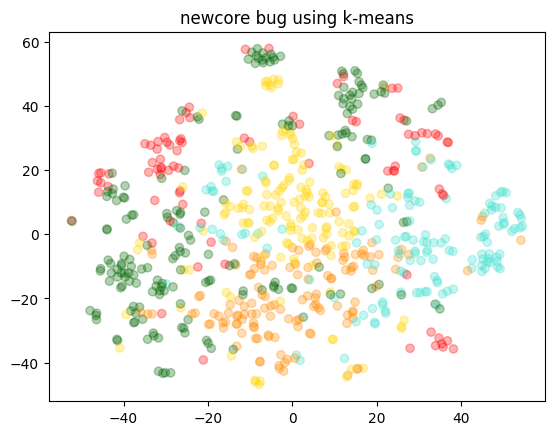

In [101]:
# 首先为每个聚类定义一个颜色。
# colors = ['red', 'green', 'blue', 'purple', 'gray']

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
# tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embedded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("newcore bug using k-means")

# 显示图形
plt.show()

**K-MEANS 聚类可视化效果，4类：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论。**

## 5. 使用 Embedding 进行文本搜索

![cosine](images/cosine.png)

In [107]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度。
from openai.embeddings_utils import get_embedding, cosine_similarity

In [102]:
type(df_embedded["embedding_vec"][0])

list

In [110]:
print(df_embedded)

                                                 title  \
704                                       生产单无法重置，重置报错   
703                           酷工厂：报表系统6天崩了3次，问题反复且未解决！   
702  nosp商品查看开通租户，切换开通租户分页时，左下角会闪一下共undefined项，右下角页...   
701                                     历史数据配置的消息通知不生效   
700                      CoreBI表格组件，数据列设置的条件样式，实际显示时不对   
..                                                 ...   
4                                  【南京川木】销售出库同步应收单数据缺失   
3    嘉益：成品入库任务下达成功，WMS那边回调成功。但是我们系统界面没有将WMS返回信息显示在任...   
2    【东莞市皖太电子科技有限公司】-物料已上传物料图，但是app的待领料列表操作的时候看不到物料...   
1    【德州敏驰】用户在APP端进行操作扫码备料出库，扫码时使用备料出库的扫码方式，此时，查看基本...   
0                              【三色鸽】对接日志显示成功，但物料没有传到U8   

                                                reason       group  business  \
704                                               历史问题    CorePaaS       酷工厂   
703                                   慢sql太密集，线上cc实例炸了  Efficiency       酷工厂   
702                                          切换分页重置了总数    CoreP

In [114]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("business: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [122]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embedded, '原代码逻辑，物料属性默认写为【产品】', n=5)

【溢达】-销售订单导入，选择新建物料，物料属性填写，半成品，但是导入新建物料后查看物料属性为产品，已在测试系统复现; 订单 Content: 原代码逻辑，物料属性默认写为【产品】

【上海雁南汽车零部件有限公司】用户从APP端，创建订单时，选择物料，通过物料规格进行筛选时，输入规格后，无法筛选出对应的规格，但是单独从APP端物料模块进行筛选的时候是可以输入物料规格后，自动弹出类似的规格，麻烦查看下是哪里的问题呢; 订单 Content: 代码问题

【湖州沃冠】用户物料：C903磁性圈胶，基本单位是g，创建BOM后，BOM的子项物料处显示的上级物料单位是个，麻烦查看下是哪里的问题呢; BOM Content: 前端代码读取父项物料基本单位不对，导致页面显示默认值”个“

【登峰优品】物料模块查询不到部分物料; 物料 Content: 修复bug导致，更新物料时，会将主物料spu es lastest字段覆盖为false，导致列表无法查询

所有租户生产单选择产品带出消耗物料清单，但没有物料规格; 酷工厂 Content: 产品设计导致漏功能



In [111]:
df_embedded['Cluster']

0      3
297    2
296    3
295    0
294    3
      ..
623    2
624    0
625    1
619    2
999    2
Name: Cluster, Length: 1000, dtype: int32

In [116]:
# 选一条类别3的评论
df_embedded['combined'][0]

'Title: 【三色鸽】对接日志显示成功，但物料没有传到U8; business: 库存 Content: 并发过高，取号器取到相同号码，后续做并发优化处理，现可点重发解决'

In [117]:
res = search_reviews(df_embedded, df_embedded['combined'][0], n=3)

【三色鸽】对接日志显示成功，但物料没有传到U8; 库存 Content: 并发过高，取号器取到相同号码，后续做并发优化处理，现可点重发解决

【三色鸽】U8对接，申请移库，传到U8传错仓库了; 集成对接 Content: u8缺少0103仓库的基础资料，mes移出仓库是0103

【亚东】库存任务-生产入库，操作入库提示：0条成功，1条失败是什么原因，比如生产单号：B-230630-004; 库存 Content: 客户开启立库，库存操作立库时会通过gateway先转发到openApi，再执行后续操作，目前问题是因为nacos被移除但gateway转发openApi的地方没做修改，导致转发失败



In [114]:
res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

Dogs Love Them!:  My Maltese and Cavalier King Charles love these treats!  I feel good about feeding them a healthier treat.<br />Not made in China!



In [115]:
res = search_reviews(df_embedded, 'awful', n=5)

God Awful:  As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once.  Both as a food aficionado and a lover of bacon, I just had to pick this up.  On

Disappointed:  The metal cover has severely disformed. And most of the cookies inside have been crushed into small pieces. Shopping experience is awful. I'll never buy it online again.

Just Bad:  Watery and unpleasant.  Like Yoohoo mixed with dirty dish water.  I find it quite odd that Keurig would release a product like this.  I'm sure they can come up with a decent hot chocolate a

Arrived in pieces:  Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money.

Awesome:  They arrived before the expected time and were of fantastic quality. Would recommend to any one looking for a awesome treat



In [ ]:
from openai.embeddings_utils import get_embedding, cosine_similarity

def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

res = search_reviews(df_embedded, 'dog food', n=3)